<a href="https://colab.research.google.com/github/chriski777/CMU_PSN_Bootcamp/blob/main/Bootcamp_Intro_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootcamp Introduction 

This notebook is meant to introduce you to the video data you'll be working with for the next few days.

Run the cell below which allows you to access the example videos and datasets. 

You will be prompted to put in an authorization code. Log in with your cmu email address and you should be given a valid code to put in the field. 


In [1]:
# Mounts Google Drive to access example videos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Once the drive is mounted, you'll have to add a shortcut to the drive containing some pilot/sample data. Head over to your google drive and then click the `Shared with me` tab on the left side menu. You should find a `PSN_bootcamp_2021` directory that Brian has shared with you. Right click this folder and then select add `shortcut to drive`. Select `My Drive` as the drive you wish to add the shortcut to. You should now have access to the pilot data that will be used in the cells below.

In [2]:
# Importing necessary packages to run these next few cells
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import HTML

## Helper Functions

Make sure to run this cell too. You can just run the cell by clicking the play button that appears when you hover over the cell below. This cell contains some helper functions that are needed for the cells below. 

In [4]:
#@title
def threshold_bp(full_df, p_cutoff):
  # Replaces x, y, and likelihood of bodyparts with likelihood < p_cutoff with NaNs
  scorer = full_df.columns.get_level_values(0)[0]
  curr_df = full_df[scorer].copy()
  for k in curr_df.columns.get_level_values(0).unique():
    # .where only replaces with np.nan if FALSE (a bit counter intuitive if you've done sql) 
    curr_df[k] = curr_df[k].where(curr_df[k]['likelihood'] > p_cutoff, np.nan)
  return curr_df
  
def calc_all_centroids(df, bodyparts):
  num_frames = df.shape[0]
  all_centroids = np.zeros((num_frames,2))
  all_centroids[:,0]= df[bodyparts].droplevel(0, axis=1)['x'].mean(axis=1).array
  all_centroids[:,1] = df[bodyparts].droplevel(0,axis=1)['y'].mean(axis=1).array
  return all_centroids

def find_centroids(df, p_cutoff):
  # Replace low likelihood bodypart values with NaNs
  replaced_df = threshold_bp(df, p_cutoff)
  all_body_parts = replaced_df.columns.unique(level='bodyparts')
  top_bp = all_body_parts[all_body_parts.str.contains('top', regex=False)]
  side_bp = all_body_parts[all_body_parts.str.contains('side', regex=False)]
  all_top_centroids = calc_all_centroids(replaced_df, top_bp)
  all_side_centroids = calc_all_centroids(replaced_df, side_bp)
  return all_top_centroids, all_side_centroids

def plot_centroids(top_centroids, side_centroids):
  fig = plt.figure(figsize=(12,6))
  ax1 = plt.subplot(211)
  plt.plot(top_centroids[:,0], label='x-coord')
  plt.plot(top_centroids[:,1], label='y-coord')
  plt.legend()
  ax1.set_title('Plot of X-Y coordinates of Top Centroid over Frames')
  ax1.set_xlabel('Frame Number')
  ax2 = plt.subplot(212)
  plt.plot(side_centroids[:,0], label='x-coord')
  plt.plot(side_centroids[:,1], label='y-coord')
  plt.legend()
  ax2.set_title('Plot of X-Y coordinates of Side Centroid over Frames')
  ax2.set_xlabel('Frame Number')
  plt.tight_layout(pad=1.0)

## Exploring our datasets

After running inference on the videos you film with your team, DeepLabCut will output two types of files: a **.mp4** file and an associated **.h5** file. 

The **.mp4** file will be a video file where each of the video's frames will be labeled by our DLC model. The **.h5** file contains information (e.g: x and y-coordinates ) about the individual labels for each frame. We'll be relying on the `opencv2` and `pandas` packages to work with these files.

In [5]:
# Feel free to replace these paths with paths to your own labeled video files
left_vid_path = '/content/drive/MyDrive/PSN_bootcamp_2021/pilot_data/solo/left_hand/labeled_video/chris_leftDLC_resnet50_DLC_handtrackMay7shuffle1_1000000_labeled.mp4'
left_hand_vc = cv2.VideoCapture(left_vid_path)
left_df = pd.read_hdf('/content/drive/MyDrive/PSN_bootcamp_2021/pilot_data/solo/left_hand/tracking_h5/chris_leftDLC_resnet50_DLC_handtrackMay7shuffle1_1000000.h5')

### Labeled Video

The **.mp4** is a video file in which each frame has been annotated by our DLC model. If you open your **.mp4** file in any video viewer (VLC, QuickTime, etc.), you should see a video similar to what you see in the cell below: 





In [6]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/pfr5Z5phNTE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Notice how each of the frames are annotated with different colored points. Each of these points correspond to *body parts* that we wish to track throughout the course of the video. We'll go into a bit more detail on what these body parts are and how they were selected in later cells.


#### Properties of Videos
Now, we'll go over some features of the video that you can extract with `opencv`. With opencv's `VideoCapture` class, we can easily access some interesting properties of our video. Here are some properties that might be helpful to know: 


*   `cv2.CAP_PROP_FRAME_COUNT`: The number of frames in your video
*   `cv2.CAP_PROP_FPS`:  Frames per second (Video Sampling rate) 
*   `cv2.CAP_PROP_FRAME_WIDTH`: Width of each frame
*   `cv2.CAP_PROP_FRAME_HEIGHT`: Height of each frame

Other properties of `VideoCapture` can be found [here](https://docs.opencv.org/3.4/d4/d15/group__videoio__flags__base.html#gaeb8dd9c89c10a5c63c139bf7c4f5704d). Make sure to replace the `cv` under the Python enumerators with `cv2`. 

In the cell below, we can take advantage of these properties to retrieve the full length (in seconds) of our video. 


In [7]:
# Feel free to replace the path below with a path to your own video
cap = cv2.VideoCapture(left_vid_path)
print(cap.get(cv2.CAP_PROP_FPS))
print("Total time of our video: %f seconds" % (cap.get(cv2.CAP_PROP_FRAME_COUNT)/cap.get(cv2.CAP_PROP_FPS)))

60.0
Total time of our video: 29.850000 seconds


We can also inspect individual frames with the following code snippet below:

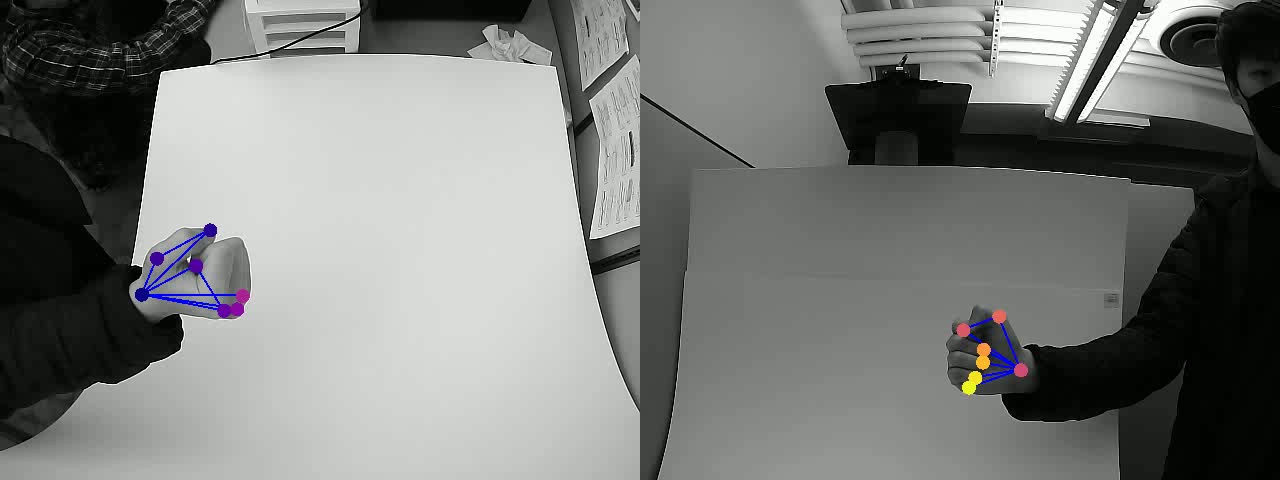

In [8]:
cap.set(cv2.CAP_PROP_POS_FRAMES,0) # Sets the current frame position of our videoCapture to the first frame.
res, frame = cap.read()
cv2_imshow(frame)

### Bodypart Labels 
As mentioned in an earlier cell, information about our bodypart labels can be found in our **.h5** files. To make these **.h5** files easier to work with, we'll be using `pandas.DataFrame` instances (e.g: `left_df`). Feel free to work in the **.h5** format if you prefer that. 

For all our videos, we'll be working with a total of 22 bodyparts (all of which were chosen before our DLC model was trained). They can be split into two groups: `Top View` and `Side View` which correspond to the two different camera angle shots each frame is composed of.

Top View | Side View
--- | ---
`0_hand_center_top` | `0_hand_center_side`
`1_tip_top` | `1_tip_side`
`1_base_top` | `1_base_side`
`2_tip_top` | `2_tip_side`
`2_base_top` | `2_base_side`
`3_tip_top` | `3_tip_side`
`3_base_top` | `3_base_side`
`4_tip_top` | `4_tip_side`
`4_base_top` | `4_base_side`
`5_tip_top` | `5_tip_side`
`5_base_top` | `5_base_side`

---
For each frame of our video and every bodypart, our dataframe will contain three types of information:

1.   X-coordinate (in pixels) of bodypart label in current frame. An x-coordinate of 0 corresponds to the leftmost pixels of your image.
2.   Y-coordinate (in pixels) of bodypart label in current frame. A y-coordinate of 0 corresponds to the pixels on top of the image.
3.   Likelihood of bodypart label in current frame. A label will **only** show up on our annotated video if it exceeds a certain arbitrarily set threshold.

Let's check out our dataframe in the cell below:

In [9]:
curr_df = left_df[left_df.columns.get_level_values(0)[0]]
curr_df

bodyparts 0_hand_center_top              ... 5_base_side           
coords                    x           y  ...           y likelihood
0                141.359543  294.161591  ...  387.120270   0.994612
1                141.508148  293.489349  ...  385.241486   0.996645
2                141.426743  293.392700  ...  385.251312   0.996595
3                141.323090  293.247833  ...  385.485718   0.993730
4                141.333160  293.272186  ...  384.341003   0.997976
...                     ...         ...  ...         ...        ...
1786             648.091614    1.020741  ...    4.615906   0.000004
1787             648.163635    1.006222  ...    4.612413   0.000004
1788             648.214600    1.100160  ...    4.324476   0.000004
1789             648.162415    1.093772  ...    4.322655   0.000004
1790             648.168274    1.089020  ...    4.326456   0.000004

[1791 rows x 66 columns]

In the dataframe above, each row corresponds to all the bodypart information for that particular frame. The number of rows in our dataframe will match the number of frames in our video. We can access the information for a specific frame with the following line of code:



In [10]:
curr_df.iloc[0] # Bodypart label information for first frame

bodyparts          coords    
0_hand_center_top  x             141.359543
                   y             294.161591
                   likelihood      0.999993
1_tip_top          x             209.944611
                   y             229.933731
                                    ...    
5_tip_side         y             377.611511
                   likelihood      0.977645
5_base_side        x             968.503662
                   y             387.120270
                   likelihood      0.994612
Name: 0, Length: 66, dtype: float64

You get out a multi-level series that you can index in the following manner. For instance, if I wanted the information associated with the center of the hand for the top view for the first frame, I'd use the following code:

In [11]:
curr_df.iloc[0]['0_hand_center_top']

coords
x             141.359543
y             294.161591
likelihood      0.999993
Name: 0, dtype: float64

Now that we covered the basics of what our data contains, we'll go over a simple example analysis that can be performed on this dataset.


# Example Analysis

In this example, using what we learned from the cells above, we'll demonstrate how one can detect stereotyped movements that emerge from playing rock-paper-scissors. 

Since we have the x-coordinates and y-coordinates of each bodypart label for each frame, we can find a top-view centroid and a side-view centroid for each frame. We can then track the trajectories of these centroids over time. In the cell below, we extract the top and side centroid for each frame of our video using our `find_centroids` function. More details on the function can be found under the Helper Functions [section](https://colab.research.google.com/drive/1JXPoW5iPk7VR3OmCN6-MPqC3XJYEN3Jq#scrollTo=hQs8owUtlKoM&line=25&uniqifier=1).

In [12]:
all_top_centroids, all_side_centroids = find_centroids(left_df, 0.7)

Once the centroids are all found, we can plot these centroids (using our function `plot_centroids` which can also be found in our Helper Functions Section) over frames to see how these centroids change over time. Based on the plot below, it becomes quite clear that we can detect two types of movements:

1.   The swinging motion of our hand before we select a sign: shown in the plot below by the wave-like fluctations 
2.   The stillness of our hand after we "throw" a sign: shown in the plot below by the flat plateaus that appear after the wave-like fluctuations

Keep in mind that the origin (0,0) for each of the frames is the top left corner of the image.

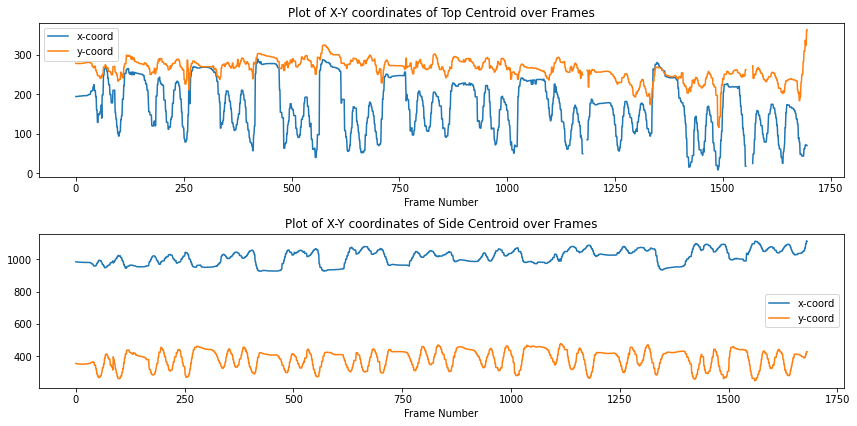

In [13]:
plot_centroids(all_top_centroids, all_side_centroids)

The youtube link below shows the trajectory of the top and side centroids (denoted by green dots) over frames stitched with the original labeled video. **Important**: The **.mp4** and **.h5** file used for this video is different from the ones used above. Thus, the plots of the centroids won't be equivalent.

In [14]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/SEkeeLbSRL4" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')